In [1]:
import saspy
import pandas as pd
from IPython.display import HTML

In [2]:
sas_session = saspy.SASsession()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 5038



Using SAS Config named: oda
SAS Connection established. Subprocess id is 5062




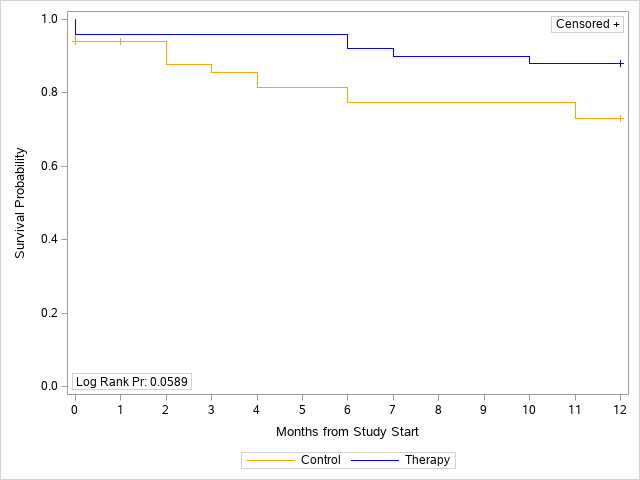

In [4]:
%%SAS

libname df "/home/sp16670/sasdata";

ods exclude SurvivalPlot HomTests HomStats ProductLimitEstimates
       Quartiles Means CensoredSummary LogrankHomCov WilcoxonHomCov ;


ods output survivalplot=surv;
ods output HomTests = pvalue;
proc lifetest data=df.timetoevent plots=(survival);
   time time * cnsr(0);
   strata treatn;
run;



data surv;
 set surv;
 if _censor_ = 0 then time3 = time;
run;

 



proc template;
  define style newblue / store=work.templat; 
  parent=styles.htmlblue;
  class graph / attrpriority='none'; 
  class GraphData1 / linestyle=3;
  class GraphData1 / linestyle=2;
 end;
run;


proc sql noprint;
 select probchisq into :pval from pvalue
 where test = "Log-Rank";
quit;


proc format;
 value $trt
 "0" = "Control"
 "1" = "Therapy"
 ;
run; 

title1 j=l "Kaplan-Meier Survival Plot";
title2 j=l "Intervention compared with control";

proc template;
   define statgraph kp_plot;
      begingraph / datacontrastcolors=(orange blue);
         layout overlay / 
            xaxisopts=(type=linear label="Months from Study Start"
               linearopts=(viewmin = 0 viewmax = 12 tickvaluesequence=(start=0 end=12 increment=1) ))
            yaxisopts=(type=linear label="Survival Probability" 
               linearopts=(viewmin = 0 viewmax = 1));
            stepplot x=time y=survival / group=stratum name="step32" 
               lineattrs=(thickness=1px);
            scatterplot x=time y=censored /group=stratum markerattrs=(symbol=plus) name="cnsr" LEGENDLABEL="Censored";
            discretelegend "step32";
            entry halign=right "Censored +" / valign=top border=true;
            entry halign=left "Log Rank Pr: &pval." / valign=bottom border=true;
         endlayout;
      endgraph;
   end;
run;

/* Render the graph */
proc sgrender data=surv template=kp_plot;
format stratum $trt.;
run;

In [5]:
sas_session.disconnect()

'Succesfully disconnected. Be sure to have a valid network connection before submitting anything else.'